In [395]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
results_file = "warp-remote-2023-02-15[112452]-1gZl.csv.zst"
df = pd.read_csv(results_file, sep="\t")

# Separate out benchmark command
warp_command = df.iloc[-1].idx
df = df.iloc[:-1]

# Drop some unused columns
df.drop(['idx'], axis=1, inplace=True)
if df.error.isna().all():
    df.drop('error', axis=1, inplace=True)
if df.n_objects.eq(1).all():
    df.drop('n_objects', axis=1, inplace=True)
    
# Define some useful function

def make_bins(df, N_bins):
    """Selects bin edges for data based on log scale and"""
    data = df.bytes / 1024**2
    min_size = round(data.min(), ndigits=4)
    max_size = round(data.max())
    return 10**np.linspace(np.log10(min_size), np.log10(max_size), N_bins+1)

def make_filesize_histogram(df, ax, N_bins=10):
    """Plots a histogram showing the distribution of file sizes in the benchmark data"""
    bins = make_bins(df, N_bins)
    data = df.bytes[df.op == "PUT"] / 1024**2
    ax.hist(data, bins=bins, histtype="bar", ec="black")
    ax.set_title("Distribution of randomized file sizes in benchmark data")
    ax.set_xlabel("File size (MiB)")
    ax.set_ylabel("File count")
    ax.set_xscale('log')
    return ax

def make_timings_plot(df, ax, op, N_bins=20):
    
    """Plots file size vs operation time info for benchmark data"""
    
    allowed_ops = df.op.unique()
    if op not in allowed_ops:
        raise Exception("op must be one of", allowed_ops)
    
    bins = make_bins(df, N_bins)
    df = df[df.op == op].copy()
    df['bytes_bin'] = np.digitize(df.bytes / 1024**2, bins)

    data = df.drop('thread', axis=1).groupby('bytes_bin').mean(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Avg")

    data = df.drop('thread', axis=1).groupby('bytes_bin').min(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Min")

    data = df.drop('thread', axis=1).groupby('bytes_bin').max(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Max")

    ax.set_title(f"Reponse times for {op} operations")
    ax.set_xlabel('File size (MiB)')
    ax.set_xscale('log')
    ax.set_ylabel('Operation time (secs)')
    ax.set_yscale('log')
    ax.legend()
    
    return ax

# Preview data
df.head(3)

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_17718/41518287.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


,thread,op,client_id,bytes,endpoint,file,start,first_byte,end,duration_ns
0,9.0,PUT,xGIc8C,7422313.0,http://fs-perf-dev-login-0:9000,3dIHlx5f/1.yLytT)zhf(yVKIMJ.rnd,2023-02-15T11:14:42.006562672Z,NaN,2023-02-15T11:14:42.117949103Z,111386431.0
1,3.0,PUT,xGIc8C,510971.0,http://fs-perf-dev-login-0:9000,Qs(f98Co/1.J3A9UUKXdlMe03)K.rnd,2023-02-15T11:14:42.007994978Z,NaN,2023-02-15T11:14:42.099122633Z,91127655.0
2,10.0,PUT,rKfgbR,7597401.0,http://fs-perf-dev-login-0:9000,phXIEQAZ/1.13OGeRyihaI2jY0H.rnd,2023-02-15T11:14:42.008135571Z,NaN,2023-02-15T11:14:42.109988751Z,101853180.0


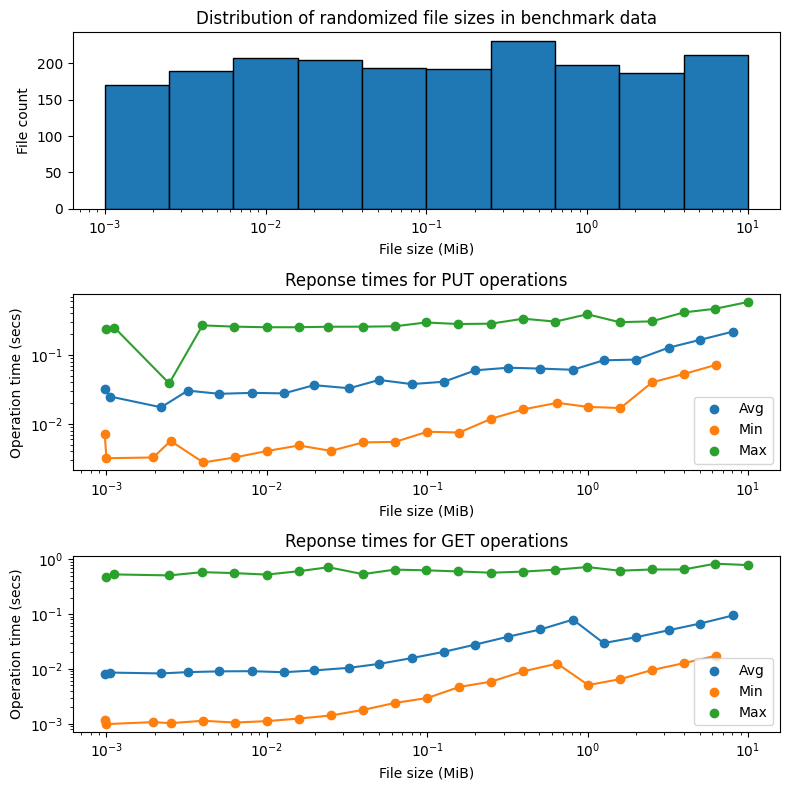

In [393]:
# Create plot 
fig, axs = plt.subplots(figsize=(8, 8), nrows=3)
make_filesize_histogram(df, axs[0])
make_timings_plot(df, axs[1], "PUT")
make_timings_plot(df, axs[2], "GET")
plt.tight_layout()
plt.show()